# Machine Unlearning Evaluation on CIFAR-10

This notebook implements a version of the machine unlearning algorithm evaluation strategy as described in "[Evaluation for the NeurIPS Machine Unlearning Competition](https://unlearning-challenge.github.io/assets/data/Machine_Unlearning_Metric.pdf)". 

In particular, it implements Algorithm 1, the *forgetting quality* $\mathcal{F}$, and the total scoring function from the above article. It also provides a version of a full scoring function, meant to be mimicking the one used for the competition, and uses it to score a "perfect" unlearning algorithm on CIFAR-10.

Note that the article does not include all details needed for reproducing the code for computing this metric, thus some gaps are filled in in an improvised manner. The following values and functions are unknown: 
* the value of $\delta$,
* the summary statistic $f$ that summarises the outpus of the models $R_i$ and $U_i$ into a scalar, and
* the attacks that yield the false positive rates (FPRs) and false negative rates (FNRs) needed for Algorithm 1.

The following values are used for this notebook:
* $\delta = 0.01$
* $f = $ cross entropy loss
* attacks = [ logistic_regression, best_threshold_attack ]



In [1]:
import os
import requests
from copy import deepcopy
from typing import Callable
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

from sklearn import linear_model, model_selection
from sklearn.metrics import make_scorer, accuracy_score

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Subset, random_split

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Running on device: CUDA


## Simple metrics

Below are several basic helper functions for computing various outputs and metrics. The `accuracy` function was introduced in the original CIFAR-10 helper notebook.`compute_outputs` simply computes the logit outputs of a given model. Importantly, it makes sure not to shuffle the data, so that samples from the forget set are grouped correctly when computing FPR and FNR later on.

In [2]:
def accuracy(net, loader):
    """Return accuracy on a dataset given by the data loader."""
    correct = 0
    total = 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return correct / total


def compute_outputs(net, loader):
    """Auxiliary function to compute the logits for all datapoints.
    Does not shuffle the data, regardless of the loader.
    """

    # Make sure loader does not shuffle the data
    if isinstance(loader.sampler, torch.utils.data.sampler.RandomSampler):
        loader = DataLoader(
            loader.dataset, 
            batch_size=loader.batch_size, 
            shuffle=False, 
            num_workers=loader.num_workers)
    
    all_outputs = []
    
    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        logits = net(inputs).detach().cpu().numpy() # (batch_size, num_classes)
        
        all_outputs.append(logits)
        
    return np.concatenate(all_outputs) # (len(loader.dataset), num_classes)


def false_positive_rate(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Computes the false positive rate (FPR)."""
    fp = np.sum(np.logical_and((y_pred == 1), (y_true == 0)))
    n = np.sum(y_true == 0)
    return fp / n


def false_negative_rate(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Computes the false negative rate (FNR)."""
    fn = np.sum(np.logical_and((y_pred == 0), (y_true == 1)))
    p = np.sum(y_true == 1)
    return fn / p


# The SCORING dictionary is used by sklearn's `cross_validate` function so that
# we record the FPR and FNR metrics of interest when doing cross validation
SCORING = {
    'false_positive_rate': make_scorer(false_positive_rate),
    'false_negative_rate': make_scorer(false_negative_rate)
}

## The summary statistic $f$

Recall that $U^s$ and $R^s$ are the distributions of (scalar) outputs of unlearned and retrained models when receiving a particular forget set example $s \in S$ as input. That is: 

$$U^s = \{ f(U_1(s)), \dots f(U_N(s)) \}$$

$$R^s = \{ f(R_1(s)), \dots f(R_N(s)) \}$$

where $M(s)$ yields the outputs obtained by feeding example s into model $M$, $f$ is the function that transforms those outputs into a scalar, and $N$ is the number of times we retrain / unlearn to obtain an approximation of the distribution of retrained / unlearned models.

The actual function $f$ used for scoring is not disclosed in the competition article. Below is an $f$ that computes the cross entropy loss between the logit output x and the highest probability class as given by the model output x. This statistic $f$ corresponds to the (negative log) probability that the model assigns to the class that the model predicts with the highest probability. 

In [3]:
def cross_entropy_f(x):
    # To ensure this function doesn't fail due to nans, find
    # all-nan rows in x and substitude them with all-zeros.
    x[np.all(np.isnan(x), axis=-1)] = np.zeros(x.shape[-1])
    
    pred = torch.tensor(np.nanargmax(x, axis = -1))
    x = torch.tensor(x)

    fn = nn.CrossEntropyLoss(reduction="none")
    
    return fn(x, pred).numpy()

## Decision rules (attacks)
Next, we define the *decision rules (attaks)* to be used when computing the forgetting quality. 

A decision rule is a function, which takes $U^s$ and $R^s$ as input, learns to predict wheather a (scalar) output $y \in U^s \bigcup R^s$ has been generated by an unlearned or a retrained model. The rule than returns the false positive rate (FPR) and the false negative rate (FNR) of the prediction.

The original article does not specify what the decision rules used are, so the ones chosen here are improvised:
* Logistic regression attack: Train a logistic regression classifier to predict whether a scalar output comes from a retrained or an unlearned model. Use cross validation and return the average FPR and FPN across different test folds.
* Best threshold attack: Consider a model that predicts that everything below certain threshold comes from the retrained model, and everything above that threshold comes from the unlearned model. Calculate the FPR and FNR for all the possible thresholds. 

In [4]:
def logistic_regression_attack(
        outputs_U, outputs_R, n_splits=2, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      outputs_U: numpy array of shape (N)
      outputs_R: numpy array of shape (N)
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      fpr, fnr : float * float
    """
    assert len(outputs_U) == len(outputs_R)
    
    samples = np.concatenate((outputs_R, outputs_U)).reshape((-1, 1))
    labels = np.array([0] * len(outputs_R) + [1] * len(outputs_U))

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    scores =  model_selection.cross_validate(
        attack_model, samples, labels, cv=cv, scoring=SCORING)
    
    fpr = np.mean(scores["test_false_positive_rate"])
    fnr = np.mean(scores["test_false_negative_rate"])
    
    return fpr, fnr


def best_threshold_attack(
        outputs_U: np.ndarray, 
        outputs_R: np.ndarray, 
        random_state: int = 0
    ) -> tuple[list[float], list[float]]:
    """Computes FPRs and FNRs for an attack that simply splits into 
    predicted positives and predited negatives based on any possible 
    single threshold.

    Args:
      outputs_U: numpy array of shape (N)
      outputs_R: numpy array of shape (N)
    Returns:
      fpr, fnr : list[float] * list[float]
    """
    assert len(outputs_U) == len(outputs_R)
    
    samples = np.concatenate((outputs_R, outputs_U))
    labels = np.array([0] * len(outputs_R) + [1] * len(outputs_U))

    N = len(outputs_U)
    
    fprs, fnrs = [], []
    for thresh in sorted(list(samples.squeeze())):
        ypred = (samples > thresh).astype("int")
        fprs.append(false_positive_rate(labels, ypred))
        fnrs.append(false_negative_rate(labels, ypred))
    
    return fprs, fnrs

## The privacy degree $\epsilon_s$, and the scoring function $\mathcal{H}$

Next we specify the function`compute_epsilon_s`, which corresponds to Algorithm 1 from the scoring article. It considers a particular example $s$ from the forget set, it takes the list of FPRs and FNRs as produced by various attacks, and computes the privacy degree $\epsilon^s$ of the example $s$. 

In [5]:
def compute_epsilon_s(fpr: list[float], fnr: list[float], delta: float) -> float:
    """Computes the privacy degree (epsilon) of a particular forget set example, 
    given the FPRs and FNRs resulting from various attacks.
    
    The smaller epsilon is, the better the unlearning is.
    
    Args:
      fpr: list[float] of length m = num attacks. The FPRs for a particular example. 
      fnr: list[float] of length m = num attacks. The FNRs for a particular example.
      delta: float
    Returns:
      epsilon: float corresponding to the privacy degree of the particular example.
    """
    assert len(fpr) == len(fnr)
    
    per_attack_epsilon = [0.]
    for fpr_i, fnr_i in zip(fpr, fnr):
        if fpr_i == 0 and fnr_i == 0:
            per_attack_epsilon.append(np.inf)
        elif fpr_i == 0 or fnr_i == 0:
            pass # discard attack
        else:
            with np.errstate(invalid='ignore'):
                epsilon1 = np.log(1. - delta - fpr_i) - np.log(fnr_i)
                epsilon2 = np.log(1. - delta - fnr_i) - np.log(fpr_i)
            if np.isnan(epsilon1) and np.isnan(epsilon2):
                per_attack_epsilon.append(np.inf)
            else:
                per_attack_epsilon.append(np.nanmax([epsilon1, epsilon2]))
            
    return np.nanmax(per_attack_epsilon)


def bin_index_fn(
        epsilons: np.ndarray, 
        bin_width: float = 0.5, 
        B: int = 13
        ) -> np.ndarray:
    """The bin index function."""
    bins = np.arange(0, B) * bin_width
    return np.digitize(epsilons, bins)


def F(epsilons: np.ndarray) -> float:
    """Computes the forgetting quality given the privacy degrees 
    of the forget set examples.
    """
    ns = bin_index_fn(epsilons)
    hs = 2. / 2 ** ns
    return np.mean(hs)

### The forgetting quality $\mathcal{F}$

The function below computes the forgetting quality $\mathcal{F}$ given only the (scalar) outputs of the $N$ retrain and $N$ unlearn models on all the forget set examples. It:
1. Iterates over each sample in $S$,
2. Performs the attacks specified to obtain lists of FPRs and FNRs,
3. Computes the privacy degree $\epsilon^s$ for each sample,
4. Computes the forgetting quality by averaging over the forget scores of all samples.

In [6]:
def forgetting_quality(
        outputs_U: np.ndarray, # (N, S)
        outputs_R: np.ndarray, # (N, S)
        attacks: list[Callable] = [logistic_regression_attack],
        delta: float = 0.01
    ):
    """
    Both `outputs_U` and `outputs_R` are of numpy arrays of ndim 2:
    * 1st dimension coresponds to the number of samples obtained from the 
      distribution of each model (N=512 in the case of the competition's leaderboard) 
    * 2nd dimension corresponds to the number of samples in the forget set (S).
    """
    
    # N = number of model samples
    # S = number of forget samples
    N, S = outputs_U.shape
    
    assert outputs_U.shape == outputs_R.shape, \
        "unlearn and retrain outputs need to be of the same shape"
    
    epsilons = []
    pbar = tqdm(range(S))
    for sample_id in pbar:
        pbar.set_description("Computing F...")
        
        sample_fprs, sample_fnrs = [], []
        
        for attack in attacks: 
            uls = outputs_U[:, sample_id]
            rls = outputs_R[:, sample_id]
            
            fpr, fnr = attack(uls, rls)
            
            if isinstance(fpr, list):
                sample_fprs.extend(fpr)
                sample_fnrs.extend(fnr)
            else:
                sample_fprs.append(fpr)
                sample_fnrs.append(fnr)
        
        sample_epsilon = compute_epsilon_s(sample_fprs, sample_fnrs, delta=delta)
        epsilons.append(sample_epsilon)
        
    return F(np.array(epsilons))

### Global scoring function

Finally, we package everything together in a single function that takes an unlearning callable, unlearns many times and outputs a dictionary of various quantities, including:
* The forget quality $\mathcal{F}$
* The various accuracies $RA^U, TA^U, RA^R, TA^R$
* The total score = $\mathcal{F} \times \frac{RA^U}{RA^R} \times \frac{TA^U}{TA^R}$

Note that since we are provided with only one retrained model for for the CIFAR dataset example, this function includes a littel hack where we add some noise to the output of that pretrained mdoel a few times, instead of pretraining from scratch. The correct version of this function would consider $N$ separate models retrained from scratch with different random seed.  

In [7]:
def score_unlearning_algorithm(
        data_loaders: dict, 
        pretrained_models: dict, 
        unlearning: Callable, 
        n: int = 10,
        delta: float = 0.01,
        f: Callable = cross_entropy_f,
        attacks: list[Callable] = [best_threshold_attack, logistic_regression_attack]
        ) -> dict:
    
    # n=512 in the case of unlearn and n=1 in the
    # case of retrain, since we are only provided with one retrained model here

    retain_loader = data_loaders["retain"]
    forget_loader = data_loaders["forget"]
    val_loader = data_loaders["validation"]
    test_loader = data_loaders["testing"]

    original_model = pretrained_models["original"]
    rt_model = pretrained_models["retrained"]

    outputs_U = []
    retain_accuracy = []
    test_accuracy = []
    forget_accuracy = []

    pbar = tqdm(range(n))
    for i in pbar:
        # unlearned model
        u_model = deepcopy(original_model)
        # Execute the unlearing routine. This might take a few minutes.
        # If run on colab, be sure to be running it on  an instance with GPUs

        pbar.set_description(f"Unlearning...")
        u_model = unlearning(u_model, retain_loader, forget_loader, val_loader)

        outputs_Ui = compute_outputs(u_model, forget_loader) 
        # The shape of outputs_Ui is (len(forget_loader.dataset), 10)
        # which for every datapoint is being cast to a scalar using the funtion f
        outputs_U.append( f(outputs_Ui) )

        pbar.set_description(f"Computing retain accuracy...")
        retain_accuracy.append(accuracy(u_model, retain_loader))

        pbar.set_description(f"Computing test accuracy...")
        test_accuracy.append(accuracy(u_model, test_loader))

        pbar.set_description(f"Computing forget accuracy...")
        forget_accuracy.append(accuracy(u_model, forget_loader))


    outputs_U = np.array(outputs_U) # (n, len(forget_loader.dataset))

    assert outputs_U.shape == (n, len(forget_loader.dataset)),\
        "Wrong shape for outputs_U. Should be (num_model_samples, num_forget_datapoints)."

    RAR = accuracy(rt_model, retain_loader)
    TAR = accuracy(rt_model, test_loader)
    FAR = accuracy(rt_model, forget_loader)

    RAU = np.mean(retain_accuracy)
    TAU = np.mean(test_accuracy)
    FAU = np.mean(forget_accuracy)

    RA_ratio = RAU / RAR
    TA_ratio = TAU / TAR

    # need to fake this a little because we only have one retrain model
    scale = np.std(outputs_U) / 10.
    outputs_Ri = compute_outputs(rt_model, forget_loader) #(len(forget_loader.dataset), 10) 
    outputs_Ri = np.expand_dims(outputs_Ri, axis=0)
    outputs_Ri = np.random.normal(
        loc=outputs_Ri, scale=scale, size=(n, *outputs_Ri.shape[-2:]))
    
    outputs_R = np.array([ f( oRi ) for oRi in outputs_Ri ])

    np.save("outputs_U.npy", outputs_U)
    np.save("outputs_R.npy", outputs_R)
    
    f = forgetting_quality(
        outputs_U, 
        outputs_R,
        attacks=attacks,
        delta=delta)

    return {
        "total_score": f * RA_ratio * TA_ratio,
        "F": f,
        "unlearn_retain_accuracy": RAU,
        "unlearn_test_accuracy": TAU, 
        "unlearn_forget_accuracy": FAU,
        "retrain_retain_accuracy": RAR,
        "retrain_test_accuracy": TAR, 
        "retrain_forget_accuracy": FAR,
        "retrain_outputs": outputs_R,
        "unlearn_outputs": outputs_U
    }

### Example 

Consider a "perfect" unlearning function, which returns the retrained model. 

In [8]:
def unlearning(net, *args, **kwargs): 
    """A placeholder prefect unlearning function, which returns 
    the retrained model. Note there is no randomness in this"""
    return deepcopy(pretrained_models["retrained"])

Load the CIFAR data splits and pretrained models.

In [9]:
from load_cifar_script import get_cifar10_data, get_cifar10_pretrained_models

data_loaders = get_cifar10_data()
pretrained_models = get_cifar10_pretrained_models(device=DEVICE)

100%|██████████| 170498071/170498071 [00:05<00:00, 33795419.46it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Score the "perfect" unlearning algorithm.

In [10]:
ret = score_unlearning_algorithm(data_loaders, pretrained_models, unlearning)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [11]:
ret

{'total_score': 0.9532114257812501,
 'F': 0.95321142578125,
 'unlearn_retain_accuracy': 0.9952666666666665,
 'unlearn_test_accuracy': 0.8796000000000002,
 'unlearn_forget_accuracy': 0.882,
 'retrain_retain_accuracy': 0.9952666666666666,
 'retrain_test_accuracy': 0.8796,
 'retrain_forget_accuracy': 0.882,
 'retrain_outputs': array([[3.76141521e-01, 6.95593952e-03, 5.40270685e-05, ...,
         1.45207440e-01, 4.72513759e-01, 2.19643186e-03],
        [3.85681042e-01, 6.95498474e-03, 5.59256025e-05, ...,
         1.42481316e-01, 4.67354550e-01, 2.19742597e-03],
        [3.76109109e-01, 6.94134841e-03, 5.36628785e-05, ...,
         1.39986226e-01, 4.62486124e-01, 2.25327036e-03],
        ...,
        [3.91361953e-01, 6.78387965e-03, 5.67867339e-05, ...,
         1.41330933e-01, 4.64775808e-01, 2.21350189e-03],
        [3.87859666e-01, 6.64971201e-03, 5.28554440e-05, ...,
         1.42432681e-01, 4.53579548e-01, 2.09323577e-03],
        [3.97167842e-01, 6.97535577e-03, 5.55023714e-05, ...,


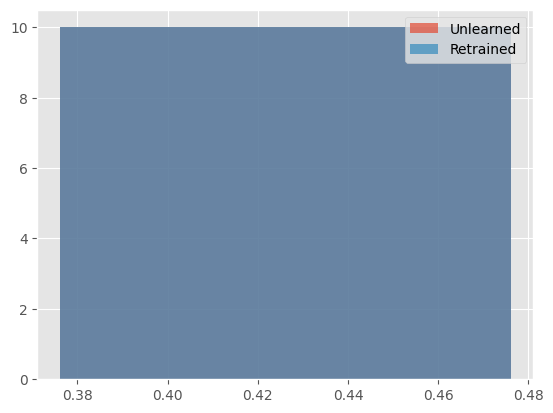

In [12]:
udata = ret["unlearn_outputs"][:,0]
rdata = ret["retrain_outputs"][:,0]
data = np.array([udata, rdata])

bins = np.arange(np.min(data), np.max(data) + 0.1, 0.1)

plt.hist(udata, bins=bins, alpha=0.7, label="Unlearned")
plt.hist(rdata, bins=bins, alpha=0.7, label="Retrained")

plt.legend()
plt.show()